# Experiment 1: Rat Mapping (2D)

In this tutorial, we will use the `optim-neurostim` library for a 2D optimization.
We will use a rat dataset, where stimuli delivered in the rat motor cortex are associated with leg muscles responses.
We will optimize the xy position of the stimulation in order to maximize the motor response.

## Step 1: Download dependencies

In [1]:
from IPython.display import Image, display
from PIL import Image as PIL_Image
import pickle
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
font = {'size': 16} 
matplotlib.rc('font', **font)

In [2]:
%cd ..

C:\Users\p117258\Documents\GitHub\EduOptimNeurostim


## Step 2: Download the dataset

In [3]:
!bash scripts/download_nhp_rat_dataset.sh data


~~~
Downloaded rat and NHP data successfully!
Ran on:      MINGW64_NT-10.0-22000 LAPTOP-M5001-01 3.3.5-341.x86_64
Duration:    0hrs 1min 8sec
~~~


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   469  100   469    0     0   1651      0 --:--:-- --:--:-- --:--:--  1657

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  3  141M    3 4504k    0     0  1803k      0  0:01:20  0:00:02  0:01:18 2308k
 11  141M   11 15.8M    0     0  4654k      0  0:00:31  0:00:03  0:00:28 5516k
 19  141M   19 27.4M    0     0  6241k      0  0:00:23  0:00:04  0:00:19 7104k
 27  141M   27 38.3M    0     0  7148k      0  0:00:20  0:00:05  0:00:15 7938k
 35  141M   35 50.2M    0     0  7914k      0  0:00:18  0:00:06  0:00:12 10.1M
 42  141M   42 60.1M    0     0  8214k      0  0:00:17  0:00:07  0:00:10 11.1M
 47  141M   47 66.9M    0     0  8065k      0  0:0

## Step 3: Configuration file

In `optim-neurostim`, the training is orchestrated by a configuration file, a JSON file containing all the necessary parameters.  Some examples of configuration files are available in the `optim-neurostim/examples/` folder.

In this tutorial for Experiment 1, we will be using the configuration file: `optim-neurostim/examples/rat_mapping_2D.json`. This is already downloaded for you in `config` (📁).

Open this file and check our repo `Readme` for more information on some of the key parameters.

## Step 4: Run optimization on one animal

Using the given config file and given that the best hyperparameter value for `kappa` is $3.0$, let's first run optimization on one new animal. We do this by passing `"{'kappa': 3.0}"` or equivalently `output/rat_mapping_2D/best_hyperparams.pkl` (i.e. path to the trained hyperparameter object) to the `-hp` flag.

Note, in some setups we encountered an "OMP: Error #15" A workaround to that error is running the following two lines (once):


import os \
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [4]:
#import os
#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

!python main.py -c config/rat_mapping_2D.json \
                -nm 1 \
                -op output/rat_mapping_2D_one_animal \
                -hp "{'kappa': 3.0}" \
                -val 

Dataset (sub:muscle):  ['rat1_M1_190716:0']
Hooray! Succesfully saved output files to output/rat_mapping_2D_one_animal.



Iterating over muscles: 100%|##########| 1/1 [00:52<00:00, 52.01s/it]


We can quickly check the performance through the saved CSV file.

In [5]:
df_gpbo = pd.read_csv('output/rat_mapping_2D_one_animal/gpbo_performance.csv', index_col='queries')
df_gpbo = df_gpbo[['exploration', 'exploitation']].T
df_gpbo

queries             1         2         3         4         5         6   \
exploration   0.090143  0.146829  0.183617  0.196898  0.205448  0.237995   
exploitation  0.090143  0.089750  0.086718  0.073510  0.084270  0.095708   

queries             7         8         9         10  ...        23        24  \
exploration   0.414886  0.453054  0.486387  0.544155  ...  0.781313  0.787205   
exploitation  0.333513  0.155227  0.215325  0.345709  ...  0.740099  0.770586   

queries             25        26        27        28        29        30  \
exploration   0.779771  0.808328  0.802436  0.812648  0.843324  0.843324   
exploitation  0.775202  0.801508  0.808328  0.808489  0.842645  0.802161   

queries             31        32  
exploration   0.843324  0.843324  
exploitation  0.833287  0.835028  

[2 rows x 32 columns]

Let's see what the `y_mu_mapped` looks like. This is the output of GP, `y_mu`, mapped to the dimensions of the problem. 

(8, 4)


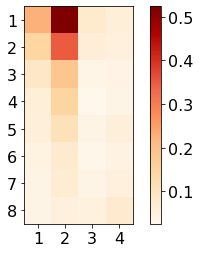

In [6]:
y_mu_mapped_arr = np.squeeze(np.load('output/rat_mapping_2D_one_animal/y_mu_mapped_arr.npy'))
print(y_mu_mapped_arr.shape)  
# NOTE: y_mu_mapped_arr is in shape (num_hyperparams, num_muscles, *system_shape) or (*system.shape) if squeeze-able
plt.xticks(range(4), range(1, 5))
plt.yticks(range(8), range(1, 9))
plt.imshow(y_mu_mapped_arr, cmap='OrRd')
plt.colorbar()
plt.show()

Let's see what algorithmic performance vs. num. queries looks like. This is essentially the same as the CSV above, but plotted nicely.

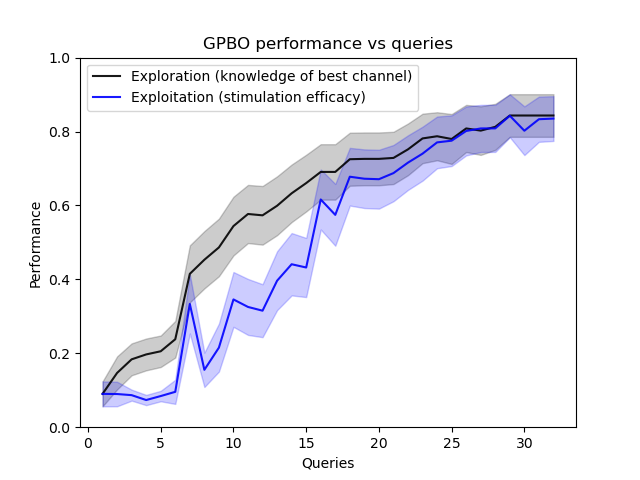

In [7]:
display(Image('output/rat_mapping_2D_one_animal/performance_vs_queries.png'))

In [8]:
channel_values_arr = np.squeeze(np.load('output/rat_mapping_2D_one_animal/channel_values_arr.npy'))
print(channel_values_arr.shape)  
print('First repetition first query channel values: ', channel_values_arr[0, 0])
# NOTE: channel_values_arr is in shape (num_hyperparams, num_muscles, num_repetitions, num_queries, num_dims)

(30, 32, 2)
First repetition first query channel values:  [7. 2.]


Let's now run GPBO again but with the `-gpu` flag enabled and compare the two results. \
(Note: if you don't have a GPU, it will run anyway on your CPU, but you won't have a gain in execution time).

In [9]:
!python main.py -c config/rat_mapping_2D.json \
                -nm 1 \
                -op output/rat_mapping_2D_one_animal_gpu \
                -hp "{'kappa': 3.0}" \
                -val \
                -gpu

Using device=cpu
Dataset (sub:muscle):  ['rat1_M1_190716:0']
Hooray! Succesfully saved output files to output/rat_mapping_2D_one_animal_gpu.



Iterating over muscles: 100%|##########| 1/1 [01:33<00:00, 93.07s/it]


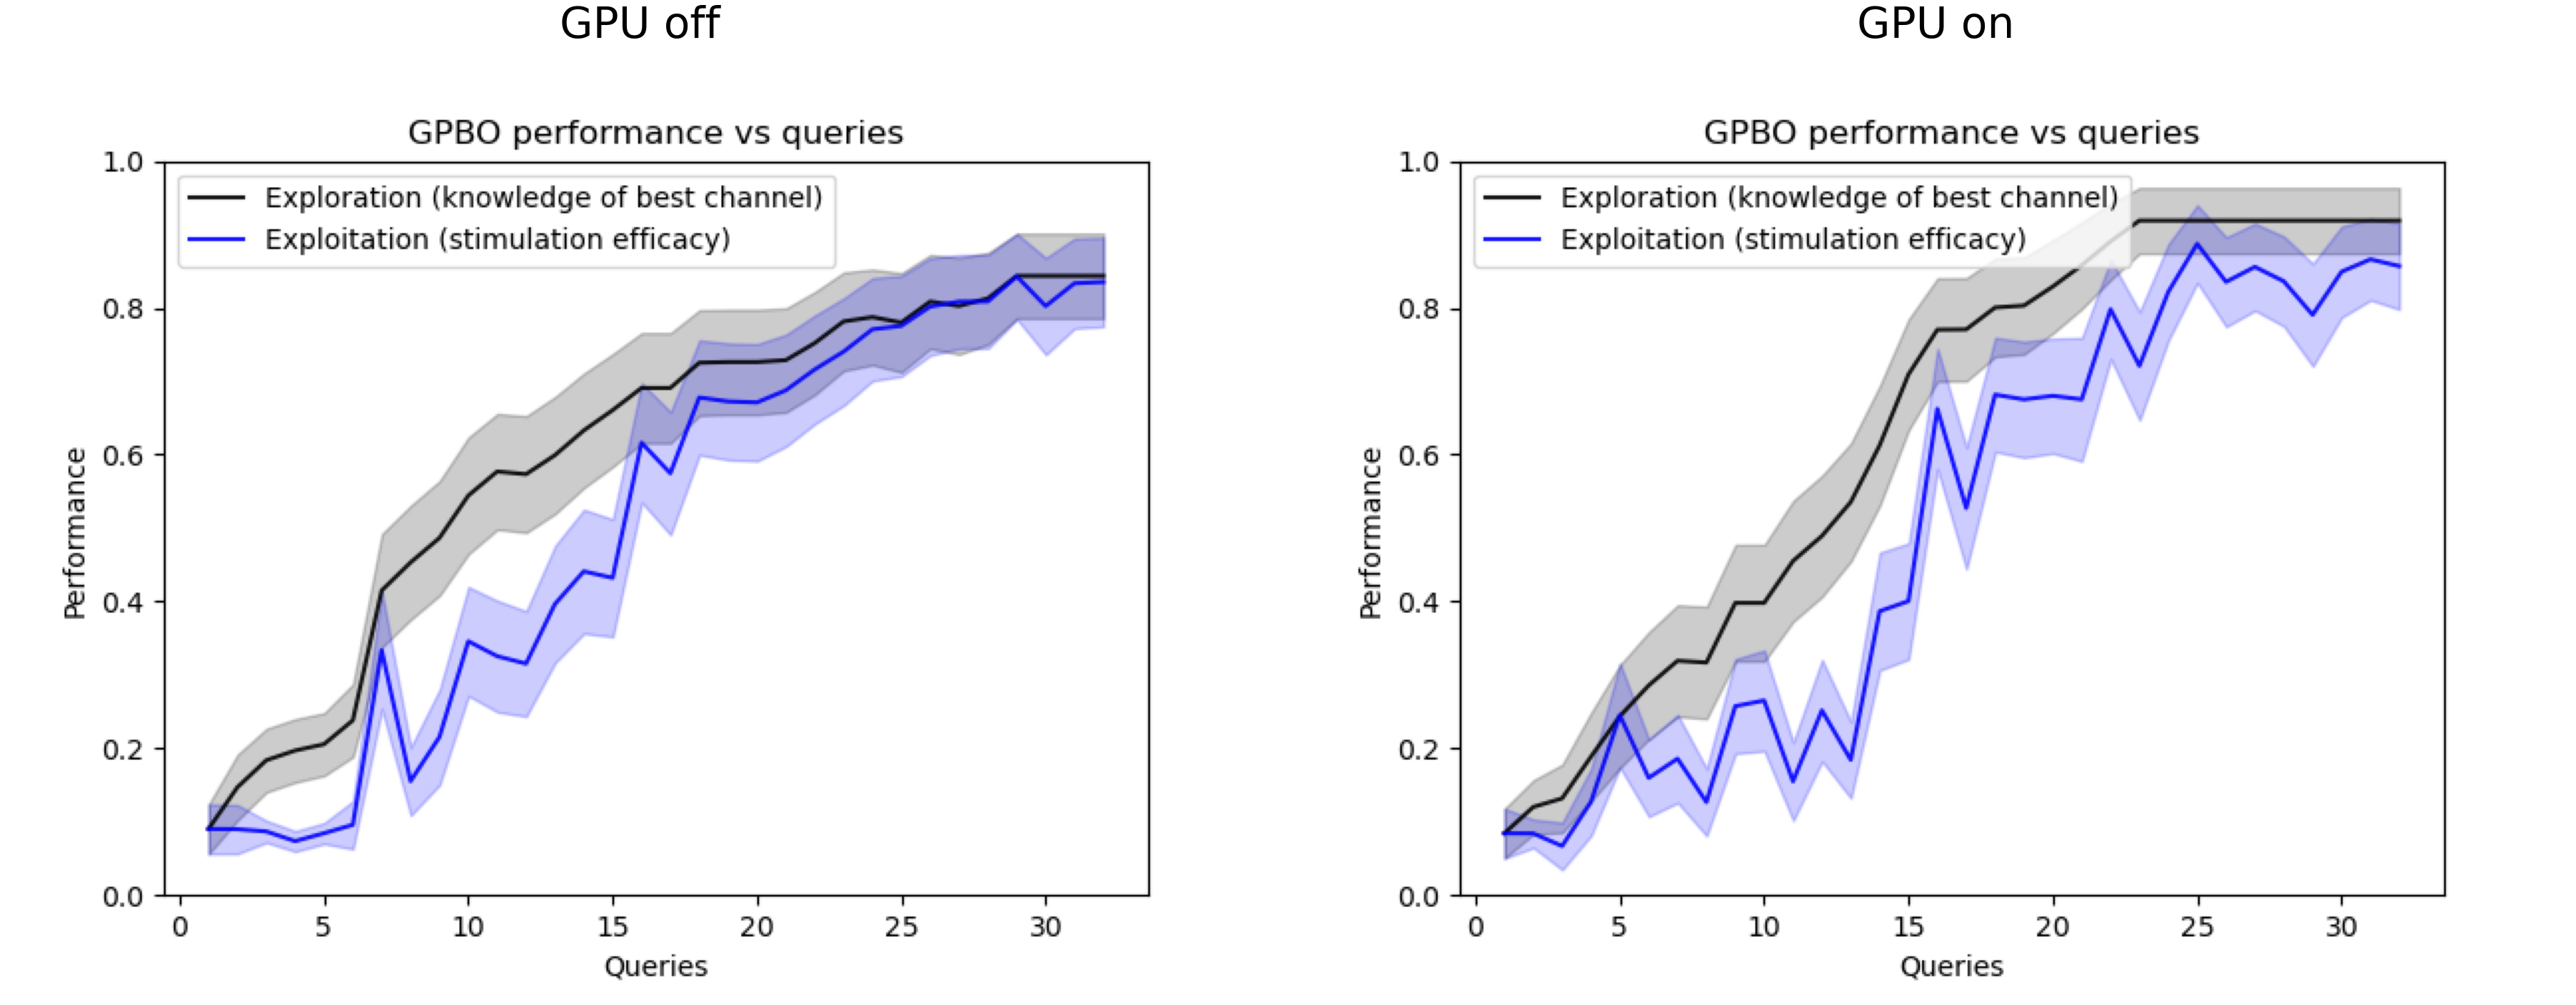

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(50, 30), constrained_layout=True)
ax[0].imshow(PIL_Image.open('output/rat_mapping_2D_one_animal/performance_vs_queries.png'))
ax[0].axis('off')
ax[0].set_title('GPU off', fontsize=60)
ax[1].imshow(PIL_Image.open('output/rat_mapping_2D_one_animal_gpu/performance_vs_queries.png'))
ax[1].axis('off')
ax[1].set_title('GPU on', fontsize=60)
plt.show()

Now, let's run the same pipeline, but using the **extensive** search algorithm instead of the **GPBO** search algorithm as employed before.

In [11]:
!python main.py -c config/rat_mapping_2D.json \
                -nm 1 \
                -alg extensive \
                -op output/rat_mapping_2D_one_animal_extensive \
                -hp "{'kappa': 3.0}" \
                -val 

Dataset (sub:muscle):  ['rat1_M1_190716:0']
Hooray! Succesfully saved output files to output/rat_mapping_2D_one_animal_extensive.



Iterating over muscles: 100%|##########| 1/1 [00:00<00:00,  5.44it/s]


We can quickly check the performance through the saved CSV file.

In [12]:
df_extensive = pd.read_csv('output/rat_mapping_2D_one_animal_extensive/extensive_performance.csv', index_col='queries')
df_extensive = df_extensive[['exploration', 'exploitation']].T
df_extensive

queries            1         2         3         4         5         6   \
exploration   0.07722  0.156304  0.175767  0.208893  0.219967  0.288749   
exploitation  0.07722  0.107633  0.059527  0.076686  0.045172  0.135034   

queries             7         8         9         10  ...        23        24  \
exploration   0.322143  0.290458  0.293669  0.326191  ...  0.550166  0.546813   
exploitation  0.091733  0.047643  0.073515  0.081486  ...  0.068784  0.047922   

queries             25        26        27        28        29        30  \
exploration   0.567936  0.620851  0.712167  0.712167  0.712167  0.712167   
exploitation  0.077292  0.154286  0.152968  0.059835  0.053889  0.091864   

queries             31        32  
exploration   0.752376  0.752376  
exploitation  0.106043  0.092700  

[2 rows x 32 columns]

Let's see what algorithmic performance vs. num. queries looks like. This is essentially the same as the CSV above, but plotted nicely.

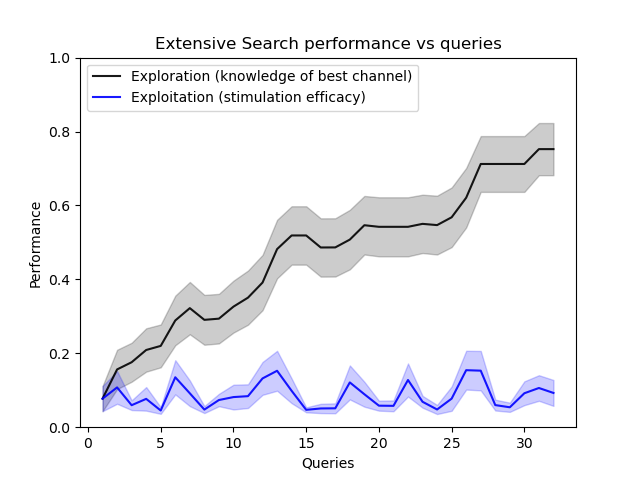

In [13]:
display(Image('output/rat_mapping_2D_one_animal_extensive/performance_vs_queries.png'))

Now, let's run the same pipeline, but using the **greedy** search algorithm instead of the **GPBO** search algorithm as employed before.

In [14]:
!python main.py -c config/rat_mapping_2D.json \
                -nm 1 \
                -alg greedy \
                -op output/rat_mapping_2D_one_animal_greedy \
                -hp "{'kappa': 3.0}" \
                -val

Dataset (sub:muscle):  ['rat1_M1_190716:0']
Hooray! Succesfully saved output files to output/rat_mapping_2D_one_animal_greedy.



Iterating over muscles: 100%|##########| 1/1 [00:00<00:00,  6.16it/s]


In [15]:
df_greedy = pd.read_csv('output/rat_mapping_2D_one_animal_greedy/greedy_performance.csv', index_col='queries')
df_greedy = df_greedy[['exploration', 'exploitation']].T
df_greedy

queries             1         2         3         4         5         6   \
exploration   0.091105  0.158845  0.198232  0.211312  0.239830  0.241480   
exploitation  0.091105  0.113446  0.077151  0.069774  0.136974  0.098591   

queries             7         8         9         10  ...        23        24  \
exploration   0.293547  0.272375  0.280701  0.346823  ...  0.685432  0.714555   
exploitation  0.115649  0.077480  0.121373  0.127587  ...  0.118379  0.199153   

queries             25        26        27        28        29        30  \
exploration   0.735679  0.768256  0.768256  0.796077  0.827489  0.848612   
exploitation  0.154811  0.252188  0.289719  0.131148  0.254238  0.125805   

queries             31        32  
exploration   0.848612  0.899276  
exploitation  0.115099  0.235676  

[2 rows x 32 columns]

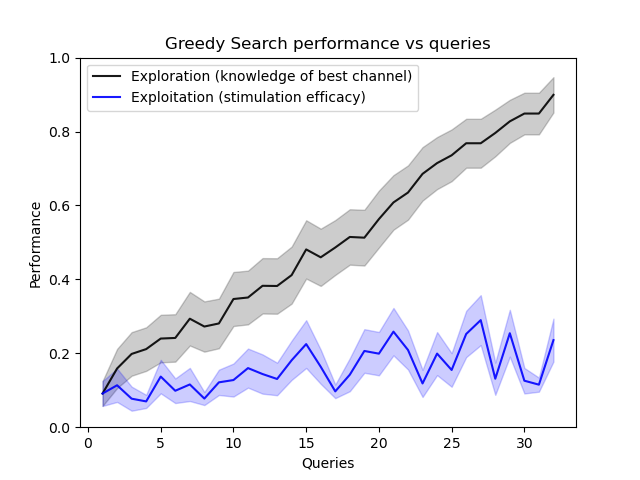

In [16]:
display(Image('output/rat_mapping_2D_one_animal_greedy/performance_vs_queries.png'))

Finally, we can compare the three algorithms on the same plot for (i) exploration and (ii) exploitation using the command given below.

In [17]:
!python scripts/compare_and_plot.py -r1 output/rat_mapping_2D_one_animal \
                                    -r2 output/rat_mapping_2D_one_animal_extensive \
                                    -r3 output/rat_mapping_2D_one_animal_greedy

Hooray! Successfully compared and plotted the runs!


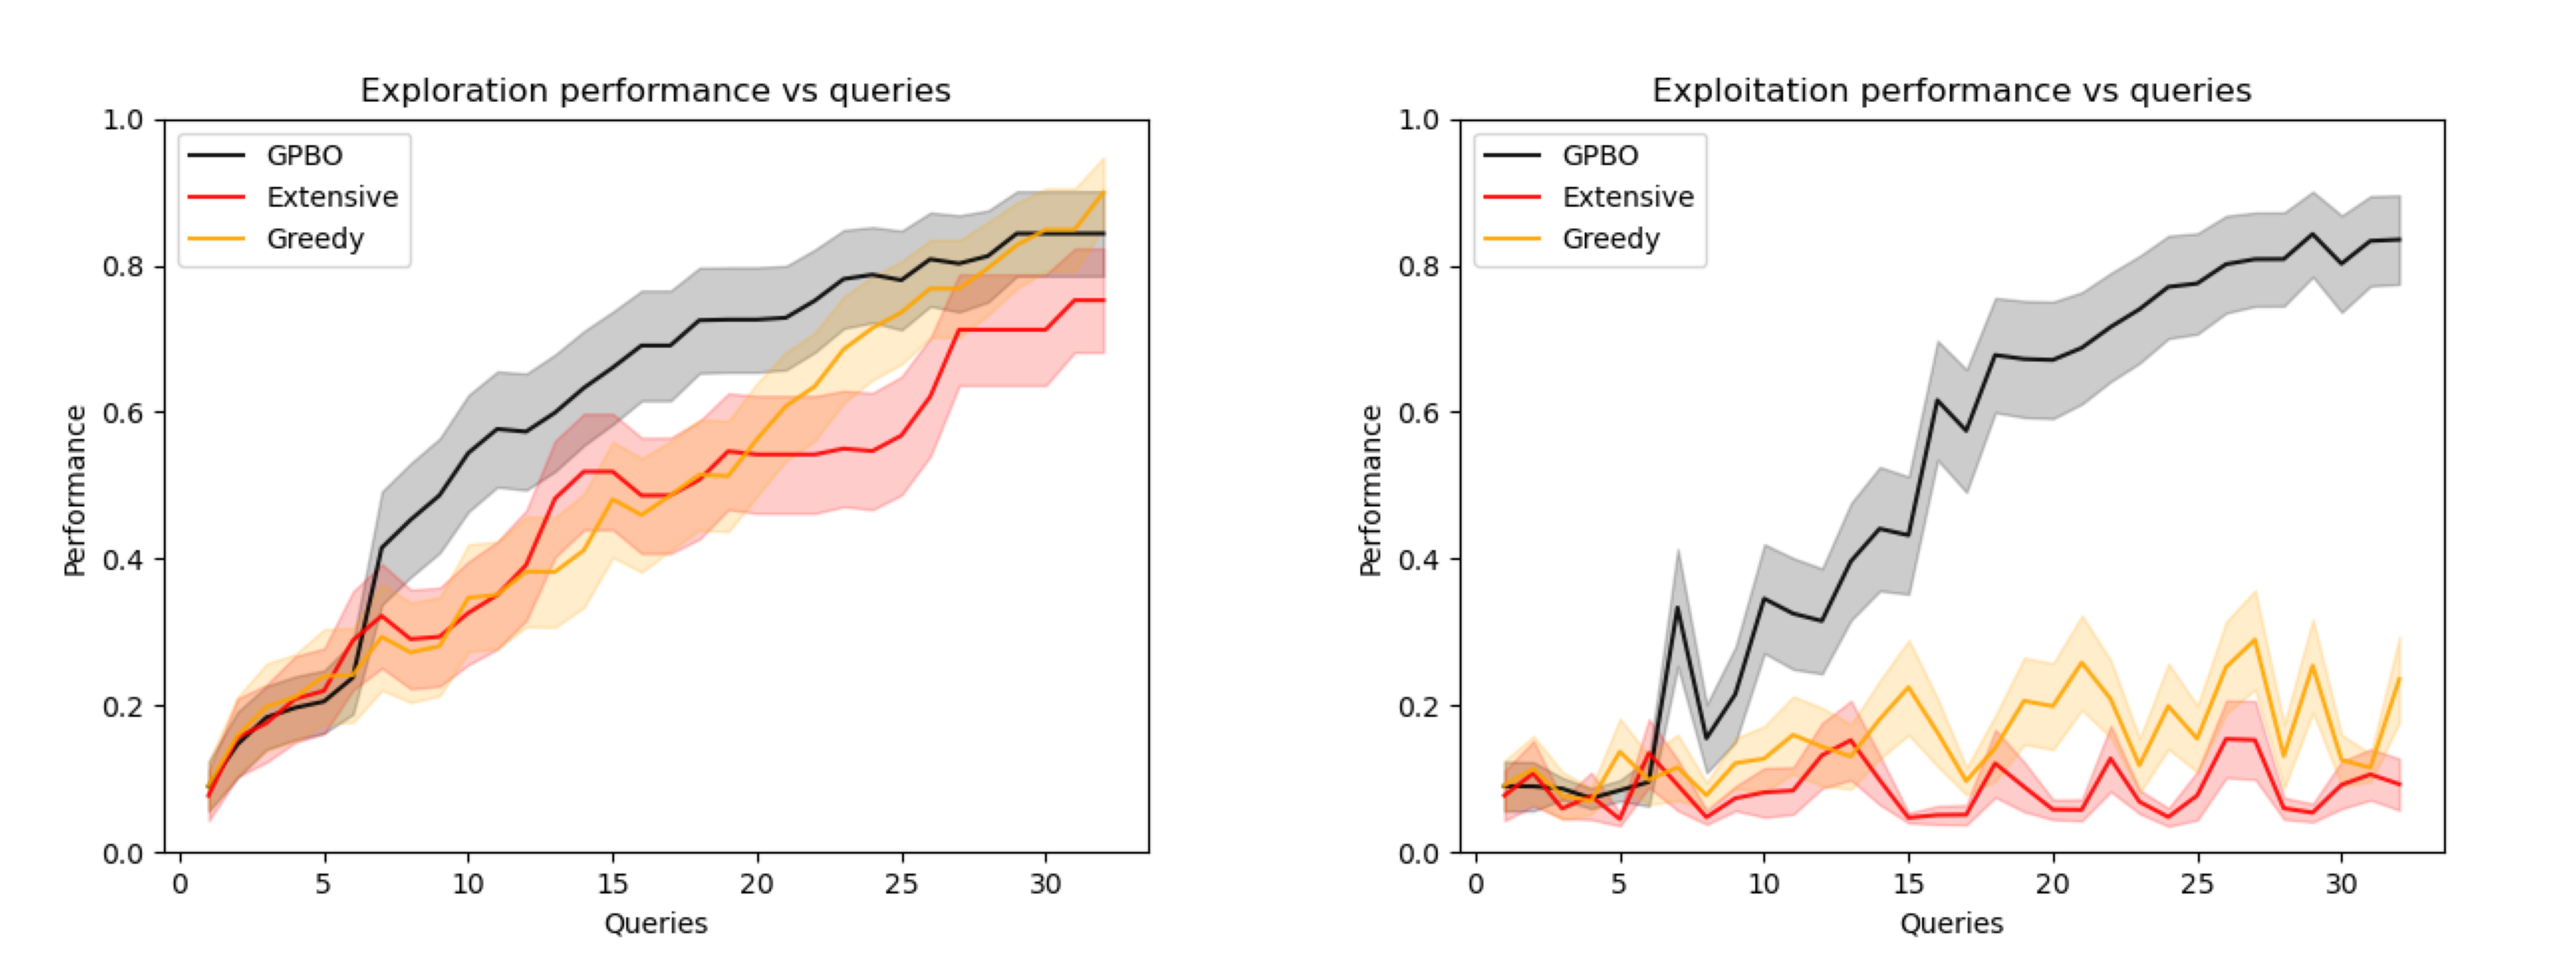

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(50, 30), constrained_layout=True)
ax[0].imshow(PIL_Image.open('output/rat_mapping_2D_one_animal/exploration_comparison.png'))
ax[0].axis('off')
ax[1].imshow(PIL_Image.open('output/rat_mapping_2D_one_animal/exploitation_comparison.png'))
ax[1].axis('off')
plt.show()

## Step 5: Run optimization on several validation replicates

We now do the same, but with several validation replicates.

In [203]:
!python main.py -c config/rat_mapping_2D.json \
                -nm 10 \
                -op output/rat_mapping_2D_several_animals \
                -hp "{'kappa': 3.0}" \
                -val

Iterating over repetitions:   3%|▌               | 1/30 [00:01<00:36,  1.27s/it] /Users/uzaymacar/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/uzaymacar/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/uzaymacar/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/uzaymacar/anaconda3/lib/python3.7/site-packages/paramz/transformations.py:119: RuntimeWarning:overflow encountered in expm1
Hooray! Succesfully saved output files to output/rat_mapping_2D_several_animals.


We can quickly check the performance through the saved CSV file.

In [204]:
df_gpbo = pd.read_csv('output/rat_mapping_2D_several_animals/gpbo_performance.csv', index_col='queries')
df_gpbo = df_gpbo[['exploration', 'exploitation']].T
df_gpbo

queries             1         2         3         4         5         6   \
exploration   0.422851  0.507812  0.553687  0.571578  0.579721  0.582863   
exploitation  0.422851  0.412381  0.399099  0.389673  0.404387  0.409355   

queries             7         8         9         10  ...        23        24  \
exploration   0.623021  0.635407  0.653235  0.670754  ...  0.764326  0.769578   
exploitation  0.496332  0.475363  0.487077  0.531210  ...  0.723499  0.744798   

queries             25        26        27        28        29        30  \
exploration   0.765072  0.773379  0.771919  0.769525  0.782397  0.782349   
exploitation  0.756620  0.751252  0.757685  0.760252  0.766432  0.769171   

queries             31        32  
exploration   0.791334  0.793285  
exploitation  0.765500  0.779786  

[2 rows x 32 columns]

Let's first see what the `y_mu_mapped` looks like. This is the output of GP, `y_mu`, mapped to the dimensions of the problem. 

(10, 8, 4)


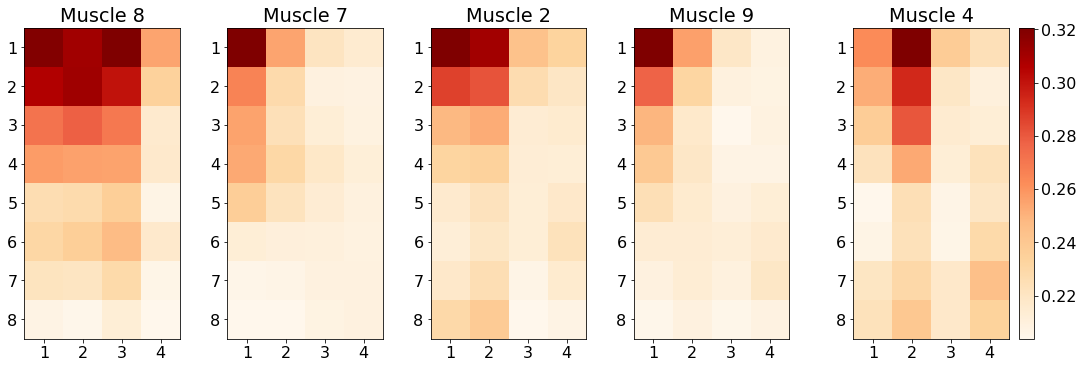

In [213]:
y_mu_mapped_arr = np.squeeze(np.load('output/rat_mapping_2D_several_animals/y_mu_mapped_arr.npy'))
print(y_mu_mapped_arr.shape)  
# NOTE: y_mu_mapped_arr is in shape (num_hyperparams, num_muscles, *system_shape) or (*system.shape) if squeeze-able
# Show 5 muscles randomly
fig, ax = plt.subplots(1, 5, figsize=(15, 5), constrained_layout=True)
for i, muscle_index in enumerate(np.random.choice(range(y_mu_mapped_arr.shape[0]), ax.shape[0], replace=False)):
    im = ax[i].imshow(y_mu_mapped_arr[muscle_index], cmap='OrRd')
    ax[i].set_title('Muscle %d' % (muscle_index + 1))
    
plt.setp(ax, xticks=range(4), xticklabels=range(1, 5), yticks=range(8), yticklabels=range(1, 9))
fig.colorbar(im, ax=ax[-1])
plt.show()  

Let's see what algorithmic performance vs. num. queries looks like. This is essentially the same as the CSV above, but plotted nicely.

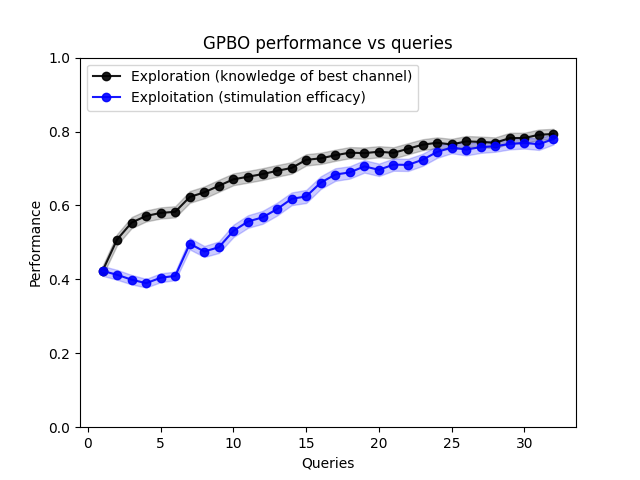

In [214]:
display(Image('output/rat_mapping_2D_several_animals/performance_vs_queries.png'))

In [83]:
!python main.py -c config/rat_mapping_2D.json \
                -nm 10 \
                -op output/rat_mapping_2D_several_animals_gpu \
                -hp "{'kappa': 3.0}" \
                -val \
                -gpu

Dataset (sub:muscle):  ['rat1_M1_190716:0', 'rat5_M1_191112:0', 'rat2_M1_190617:6', 'rat4_M1_191109:0', 'rat5_M1_191112:2', 'rat3_M1_190728:2', 'rat6_M1_200218:6', 'rat6_M1_200218:2', 'rat1_M1_190716:1', 'rat3_M1_190728:7']
Hooray! Succesfully saved output files to output/rat_mapping_2D_several_animals_gpu.


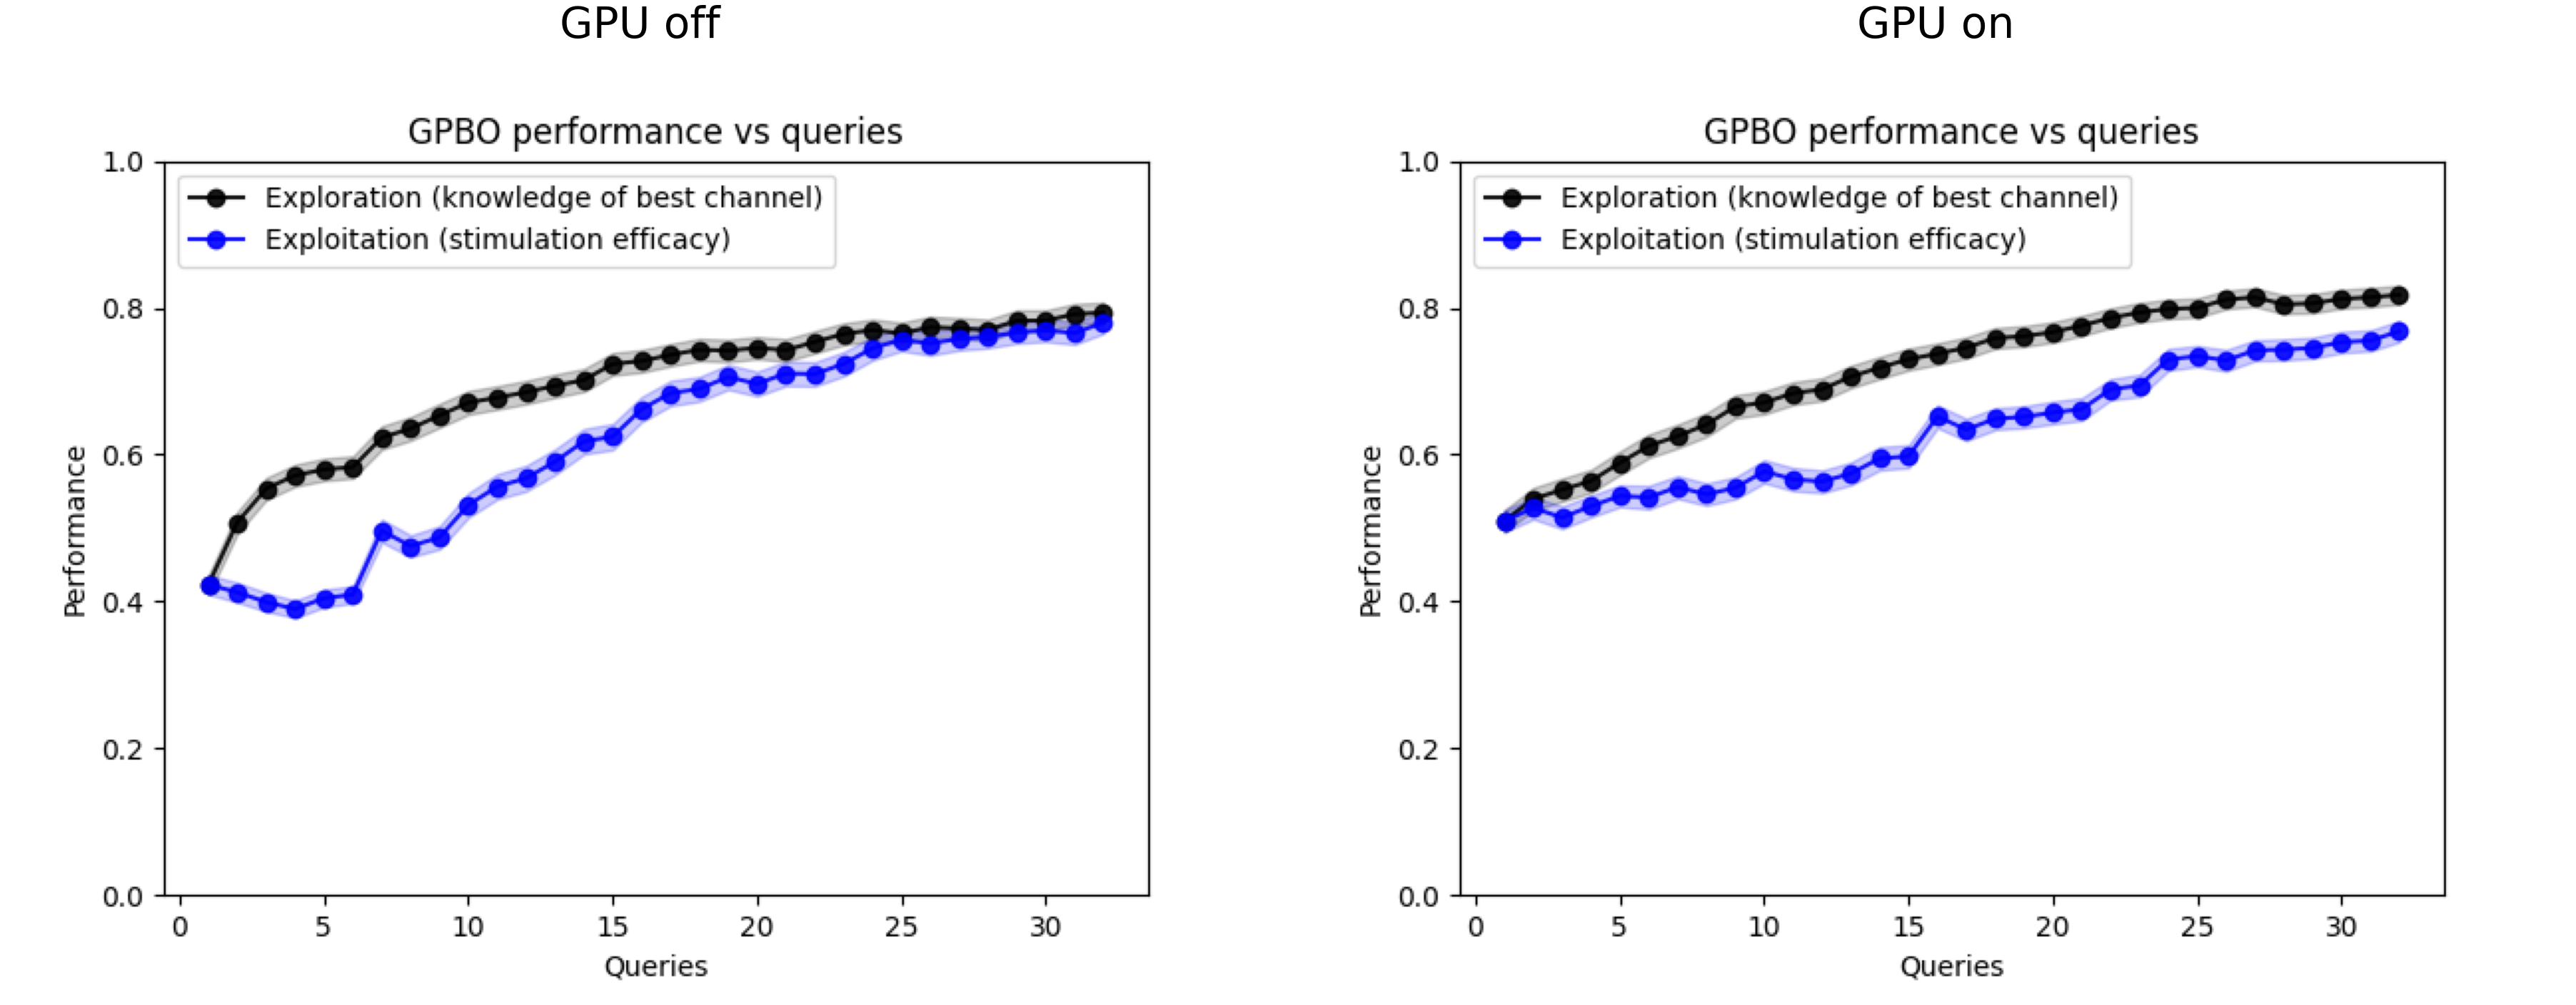

In [84]:
fig, ax = plt.subplots(1, 2, figsize=(50, 30), constrained_layout=True)
ax[0].imshow(PIL_Image.open('output/rat_mapping_2D_several_animals/performance_vs_queries.png'))
ax[0].axis('off')
ax[0].set_title('GPU off', fontsize=60)
ax[1].imshow(PIL_Image.open('output/rat_mapping_2D_several_animals_gpu/performance_vs_queries.png'))
ax[1].axis('off')
ax[1].set_title('GPU on', fontsize=60)
plt.show()

Now, let's run the same pipeline, but using the **extensive** search algorithm instead of the **GPBO** search algorithm as employed before.

In [215]:
!python main.py -c config/rat_mapping_2D.json \
                -nm 10 \
                -alg extensive \
                -op output/rat_mapping_2D_several_animals_extensive \
                -hp "{'kappa': 3.0}" \
                -val 

Iterating over repetitions:  97%|██████████████▌| 29/30 [00:44<00:01,  1.38s/it] /Users/uzaymacar/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/uzaymacar/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
Hooray! Succesfully saved output files to output/rat_mapping_2D_several_animals_extensive.


We can quickly check the performance through the saved CSV file.

In [216]:
df_extensive = pd.read_csv('output/rat_mapping_2D_several_animals_extensive/extensive_performance.csv', index_col='queries')
df_extensive = df_extensive[['exploration', 'exploitation']].T
df_extensive

queries             1         2         3         4         5         6   \
exploration   0.404341  0.448241  0.474143  0.500755  0.510465  0.537788   
exploitation  0.404341  0.402212  0.401972  0.411289  0.403244  0.422560   

queries             7         8         9         10  ...        23        24  \
exploration   0.556186  0.579802  0.586151  0.592036  ...  0.652825  0.653314   
exploitation  0.391987  0.425179  0.405853  0.403774  ...  0.395998  0.420320   

queries             25        26        27        28        29        30  \
exploration   0.657110  0.667584  0.678045  0.680528  0.678677  0.682830   
exploitation  0.399149  0.411957  0.419296  0.402645  0.398403  0.417446   

queries             31        32  
exploration   0.688908  0.695320  
exploitation  0.393798  0.410493  

[2 rows x 32 columns]

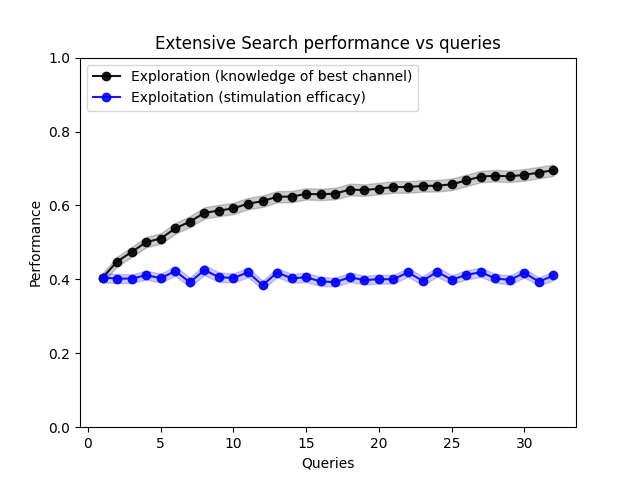

In [217]:
display(Image('output/rat_mapping_2D_several_animals_extensive/performance_vs_queries.png'))

In [3]:
!python main.py -c config/rat_mapping_2D.json \
                -nm 10 \
                -alg greedy \
                -op output/rat_mapping_2D_several_animals_greedy \
                -hp "{'kappa': 3.0}" \
                -val 

Dataset (sub:muscle):  ['rat1_M1_190716:0', 'rat5_M1_191112:0', 'rat2_M1_190617:6', 'rat4_M1_191109:0', 'rat5_M1_191112:2', 'rat3_M1_190728:2', 'rat6_M1_200218:6', 'rat6_M1_200218:2', 'rat1_M1_190716:1', 'rat3_M1_190728:7']
Iterating over repetitions:  57%|████████▌      | 17/30 [00:19<00:15,  1.16s/it] /Users/uzaymacar/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/uzaymacar/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/uzaymacar/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
Hooray! Succesfully saved output files to output/rat_mapping_2D_several_animals_greedy.


In [4]:
df_greedy = pd.read_csv('output/rat_mapping_2D_several_animals_greedy/greedy_performance.csv', index_col='queries')
df_greedy = df_greedy[['exploration', 'exploitation']].T
df_greedy

queries            1         2         3         4         5         6   \
exploration   0.51398  0.528040  0.548038  0.563010  0.597039  0.594693   
exploitation  0.51398  0.501903  0.491884  0.503101  0.556498  0.509528   

queries             7         8         9         10  ...        23        24  \
exploration   0.599401  0.600499  0.629256  0.638214  ...  0.719321  0.720387   
exploitation  0.515274  0.523519  0.567804  0.532905  ...  0.508534  0.522529   

queries             25        26        27        28        29        30  \
exploration   0.729115  0.728439  0.731103  0.733848  0.733653  0.736360   
exploitation  0.525299  0.499687  0.517041  0.503449  0.511079  0.517555   

queries             31        32  
exploration   0.735660  0.735691  
exploitation  0.514858  0.515987  

[2 rows x 32 columns]

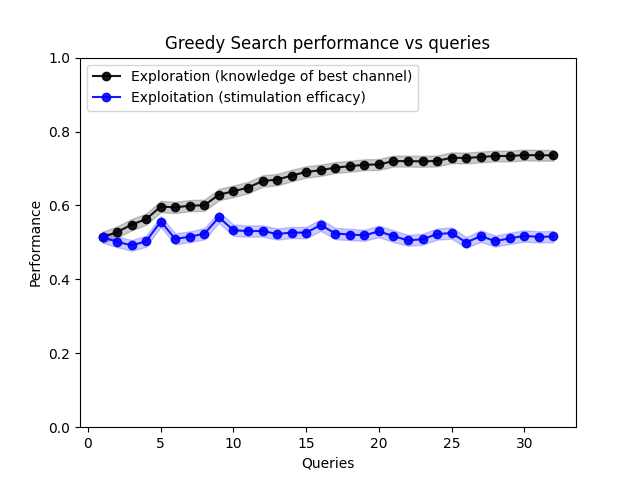

In [5]:
display(Image('output/rat_mapping_2D_several_animals_greedy/performance_vs_queries.png'))

Finally, we can compare the three algorithms on the same plot for (i) exploration and (ii) exploitation using the command given below.

In [6]:
!python scripts/compare_and_plot.py -r1 output/rat_mapping_2D_several_animals \
                                    -r2 output/rat_mapping_2D_several_animals_extensive \
                                    -r3 output/rat_mapping_2D_several_animals_greedy

Hooray! Successfully compared and plotted the runs!


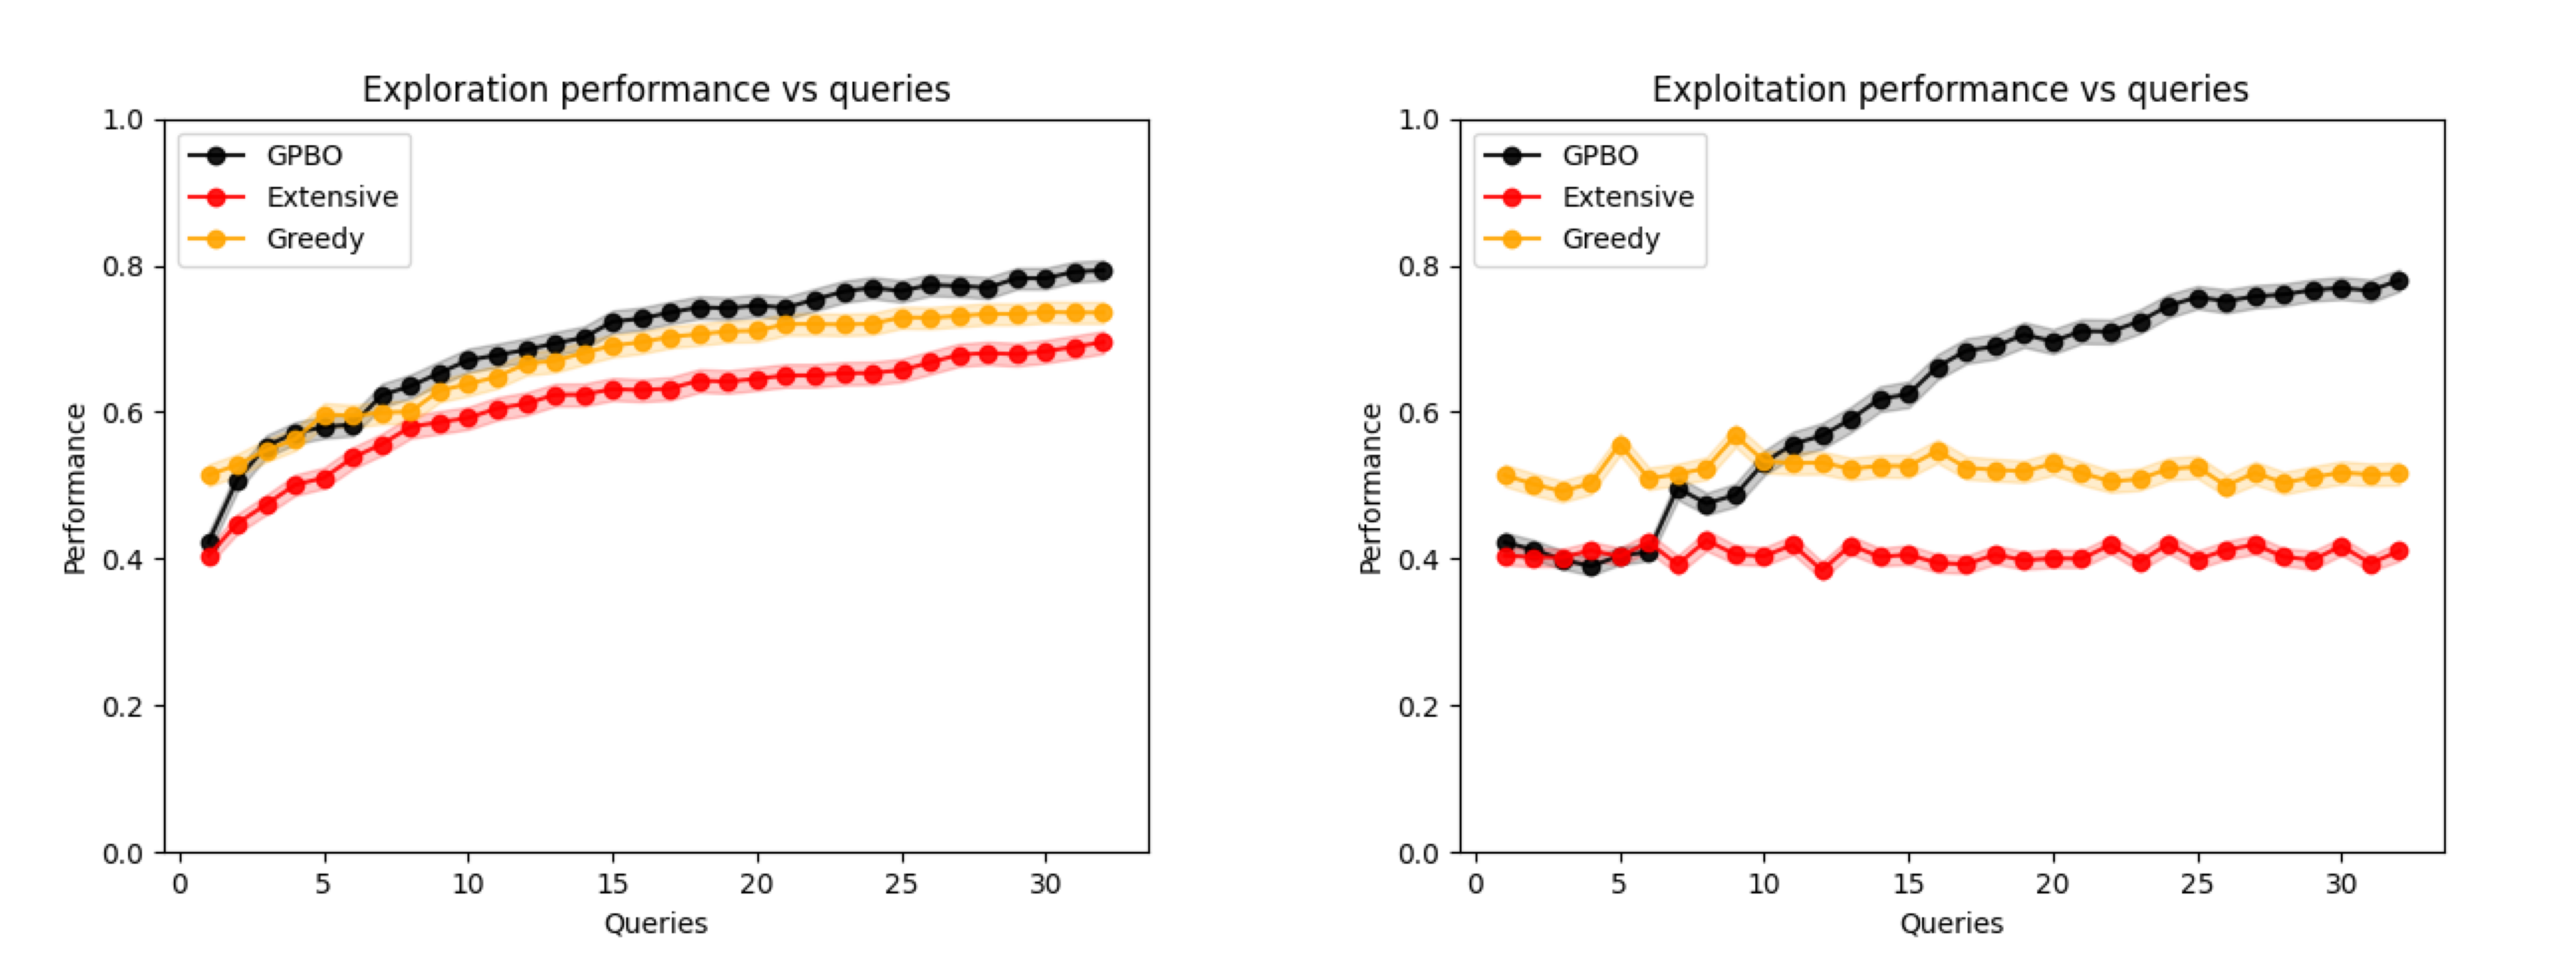

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(50, 30), constrained_layout=True)
ax[0].imshow(PIL_Image.open('output/rat_mapping_2D_several_animals/exploration_comparison.png'))
ax[0].axis('off')
ax[1].imshow(PIL_Image.open('output/rat_mapping_2D_several_animals/exploitation_comparison.png'))
ax[1].axis('off')
plt.show()

## Running validation on all replicates

In [83]:
!python main.py -c config/rat_mapping_2D.json \
                -op output/rat_mapping_2D_all \
                -hp "{'kappa': 3.0}" \
                -val

Dataset (sub:muscle):  ['rat1_M1_190716:0', 'rat5_M1_191112:0', 'rat2_M1_190617:6', 'rat4_M1_191109:0', 'rat5_M1_191112:2', 'rat3_M1_190728:2', 'rat6_M1_200218:6', 'rat6_M1_200218:2', 'rat1_M1_190716:1', 'rat3_M1_190728:7', 'rat2_M1_190617:1', 'rat1_M1_190716:5', 'rat2_M1_190617:4', 'rat3_M1_190728:0', 'rat3_M1_190728:1', 'rat6_M1_200218:5', 'rat4_M1_191109:1', 'rat6_M1_200218:7', 'rat4_M1_191109:2', 'rat3_M1_190728:4', 'rat2_M1_190617:2', 'rat6_M1_200218:3', 'rat1_M1_190716:3', 'rat6_M1_200218:1', 'rat2_M1_190617:3', 'rat1_M1_190716:4', 'rat6_M1_200218:4', 'rat2_M1_190617:0', 'rat5_M1_191112:1', 'rat3_M1_190728:5', 'rat2_M1_190617:5', 'rat5_M1_191112:3', 'rat3_M1_190728:6', 'rat4_M1_191109:4', 'rat5_M1_191112:4', 'rat6_M1_200218:0', 'rat3_M1_190728:3', 'rat1_M1_190716:2', 'rat4_M1_191109:5', 'rat4_M1_191109:3']
Iterating over repetitions:  57%|████████▌      | 17/30 [00:27<00:24,  1.91s/it] /Users/uzaymacar/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:166: RuntimeW

In [71]:
!python main.py -c config/rat_mapping_2D.json \
                -alg extensive \
                -op output/rat_mapping_2D_all_extensive \
                -hp "{'kappa': 3.0}" \
                -val

Dataset (sub:muscle):  ['rat1_M1_190716:0', 'rat5_M1_191112:0', 'rat2_M1_190617:6', 'rat4_M1_191109:0', 'rat5_M1_191112:2', 'rat3_M1_190728:2', 'rat6_M1_200218:6', 'rat6_M1_200218:2', 'rat1_M1_190716:1', 'rat3_M1_190728:7', 'rat2_M1_190617:1', 'rat1_M1_190716:5', 'rat2_M1_190617:4', 'rat3_M1_190728:0', 'rat3_M1_190728:1', 'rat6_M1_200218:5', 'rat4_M1_191109:1', 'rat6_M1_200218:7', 'rat4_M1_191109:2', 'rat3_M1_190728:4', 'rat2_M1_190617:2', 'rat6_M1_200218:3', 'rat1_M1_190716:3', 'rat6_M1_200218:1', 'rat2_M1_190617:3', 'rat1_M1_190716:4', 'rat6_M1_200218:4', 'rat2_M1_190617:0', 'rat5_M1_191112:1', 'rat3_M1_190728:5', 'rat2_M1_190617:5', 'rat5_M1_191112:3', 'rat3_M1_190728:6', 'rat4_M1_191109:4', 'rat5_M1_191112:4', 'rat6_M1_200218:0', 'rat3_M1_190728:3', 'rat1_M1_190716:2', 'rat4_M1_191109:5', 'rat4_M1_191109:3']
Iterating over repetitions:   0%|                        | 0/30 [00:00<?, ?it/s] main.py:469: RuntimeWarning:Mean of empty slice
 main.py:465: RuntimeWarning:invalid value enco

In [72]:
!python main.py -c config/rat_mapping_2D.json \
                -alg greedy \
                -op output/rat_mapping_2D_all_greedy \
                -hp "{'kappa': 3.0}" \
                -val 

Dataset (sub:muscle):  ['rat1_M1_190716:0', 'rat5_M1_191112:0', 'rat2_M1_190617:6', 'rat4_M1_191109:0', 'rat5_M1_191112:2', 'rat3_M1_190728:2', 'rat6_M1_200218:6', 'rat6_M1_200218:2', 'rat1_M1_190716:1', 'rat3_M1_190728:7', 'rat2_M1_190617:1', 'rat1_M1_190716:5', 'rat2_M1_190617:4', 'rat3_M1_190728:0', 'rat3_M1_190728:1', 'rat6_M1_200218:5', 'rat4_M1_191109:1', 'rat6_M1_200218:7', 'rat4_M1_191109:2', 'rat3_M1_190728:4', 'rat2_M1_190617:2', 'rat6_M1_200218:3', 'rat1_M1_190716:3', 'rat6_M1_200218:1', 'rat2_M1_190617:3', 'rat1_M1_190716:4', 'rat6_M1_200218:4', 'rat2_M1_190617:0', 'rat5_M1_191112:1', 'rat3_M1_190728:5', 'rat2_M1_190617:5', 'rat5_M1_191112:3', 'rat3_M1_190728:6', 'rat4_M1_191109:4', 'rat5_M1_191112:4', 'rat6_M1_200218:0', 'rat3_M1_190728:3', 'rat1_M1_190716:2', 'rat4_M1_191109:5', 'rat4_M1_191109:3']
Iterating over repetitions:   0%|                        | 0/30 [00:00<?, ?it/s] main.py:469: RuntimeWarning:Mean of empty slice
Hooray! Succesfully saved output files to outpu

In [73]:
!python scripts/compare_and_plot.py -r1 output/rat_mapping_2D_all \
                                    -r2 output/rat_mapping_2D_all_extensive \
                                    -r3 output/rat_mapping_2D_all_greedy

Hooray! Successfully compared and plotted the runs!


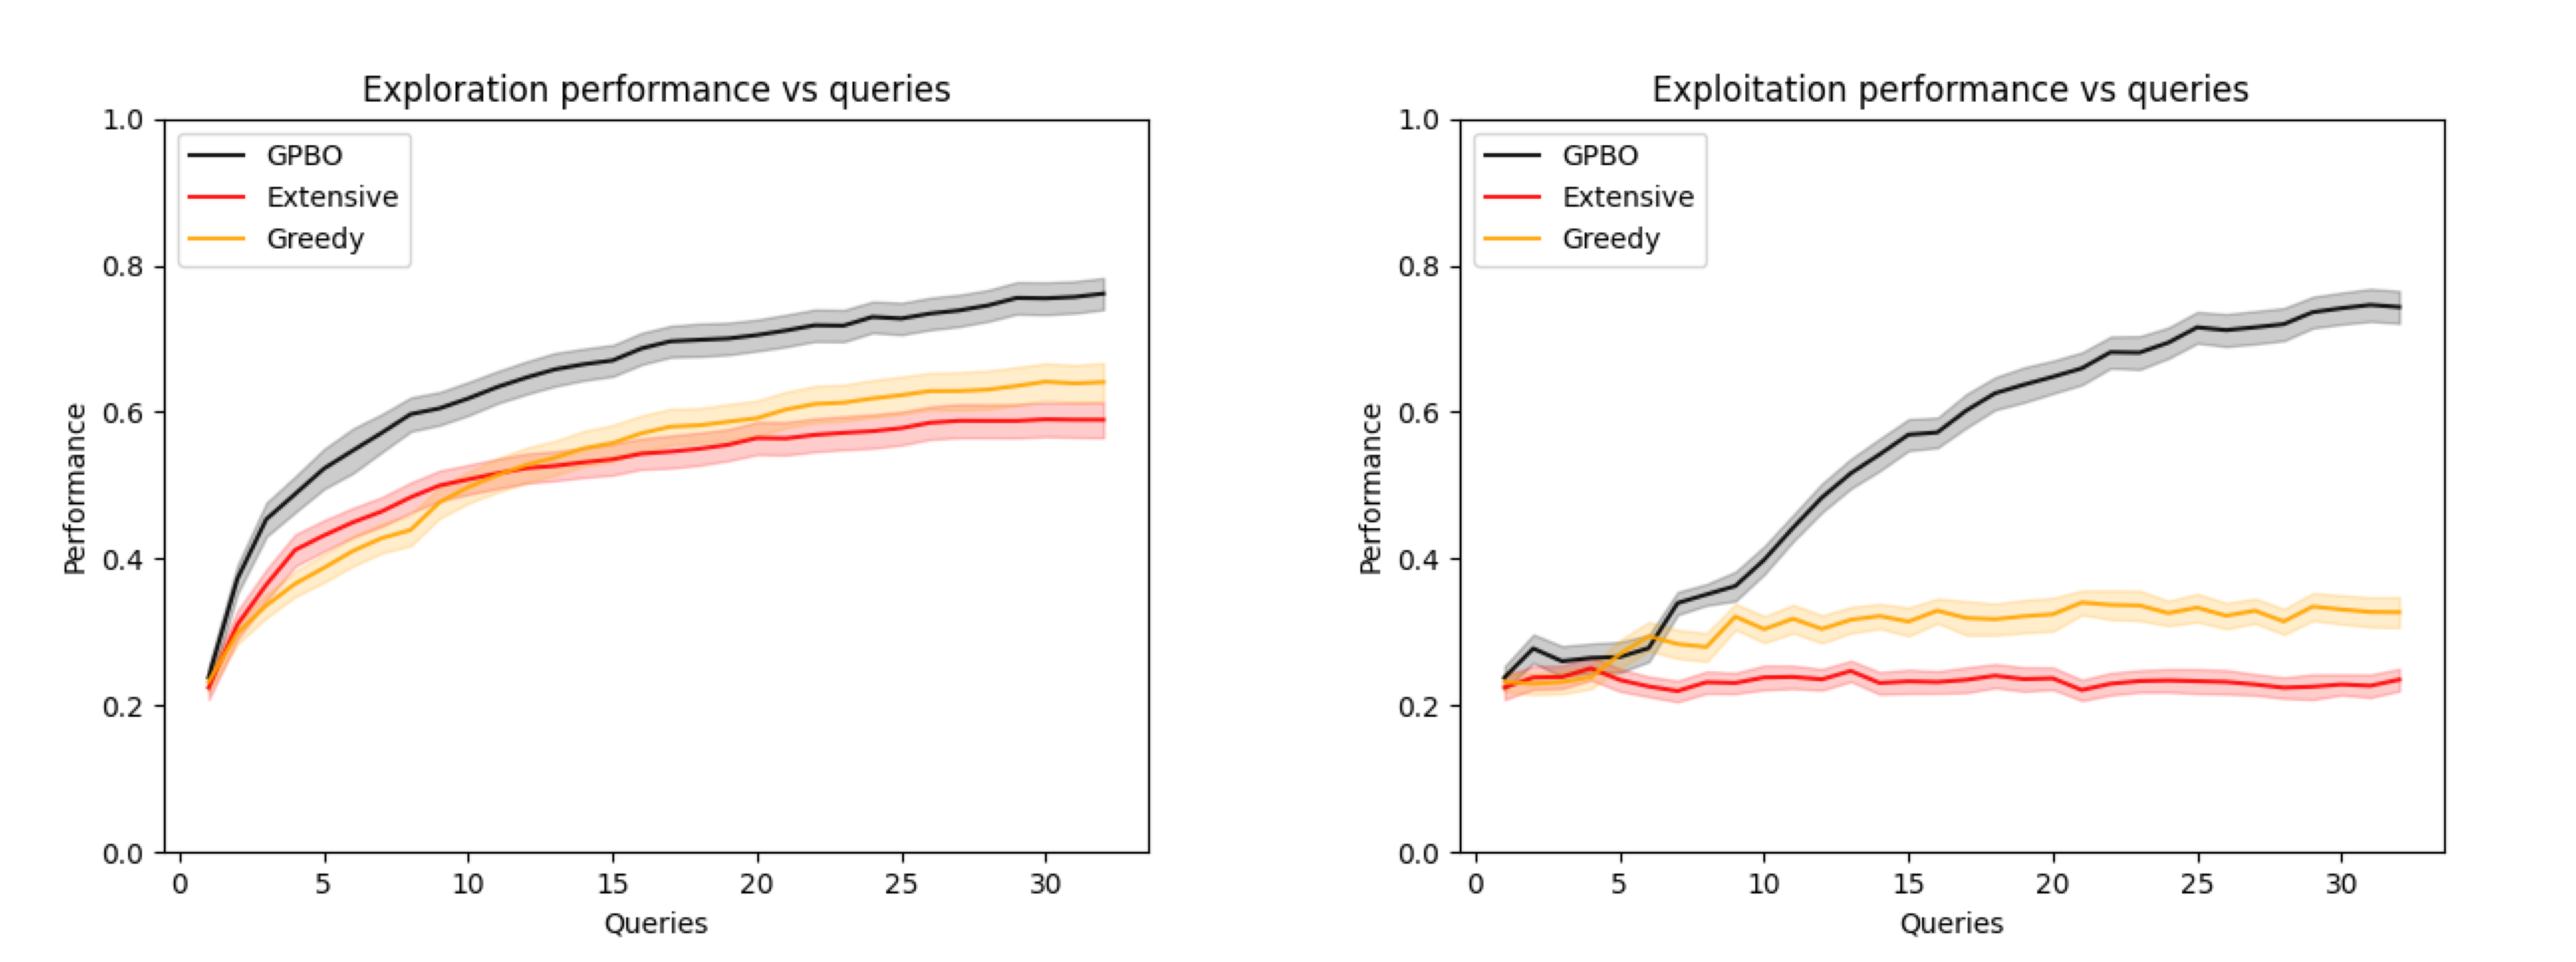

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(50, 30), constrained_layout=True)
ax[0].imshow(PIL_Image.open('output/rat_mapping_2D_all/exploration_comparison.png'))
ax[0].axis('off')
ax[1].imshow(PIL_Image.open('output/rat_mapping_2D_all/exploitation_comparison.png'))
ax[1].axis('off')
plt.show()

## Step 6: Run offline hyperpamater optimization

Now that we saw how `optim-neurostim` can be utilized to run validation experiments, let's see how we decided on the best value for `kappa`. Now, we will run the command without any additional flags to perform offline hyperparameter optimization. As discussed before, the config file encodes all of the necessary information.

In [4]:
!python main.py -c config/rat_mapping_2D.json \
                -op output/rat_mapping_2D

Iterating over repetitions:  27%|████▎           | 8/30 [00:09<00:26,  1.19s/it] /Users/uzaymacar/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/uzaymacar/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/uzaymacar/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/uzaymacar/anaconda3/lib/python3.7/site-packages/paramz/transformations.py:119: RuntimeWarning:overflow encountered in expm1
Iterating over repetitions:  27%|████▎           | 8/30 [00:09<00:26,  1.20s/it] /Users/uzaymacar/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:overflow encountered in add
Hooray! Succesfully saved output files to output/rat_mapping_2D.                


Let's first see what the algorithmic performance looks like for different values of hyperparameter `kappa`.

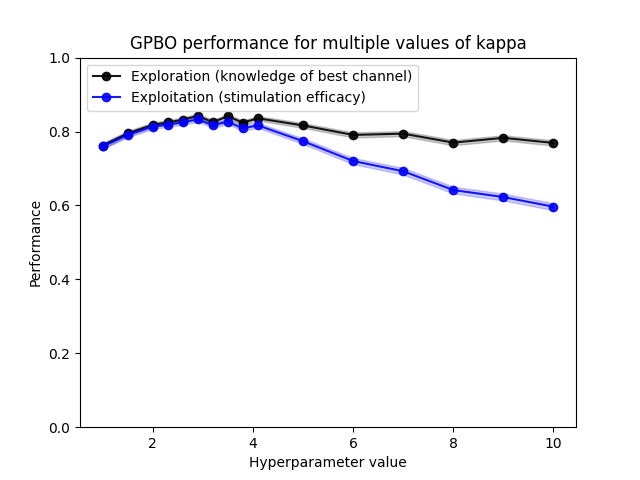

In [5]:
display(Image('output/rat_mapping_2D/performance_for_kappa.png'))

This command also gives us a `.pkl` containing the best values for hyperparameters which we can pass onto validation experiments later. Let's investigate this below.

In [6]:
with open('output/rat_mapping_2D/best_hyperparams.pkl', 'rb') as f:
    d = pickle.load(f)

print(d)

{'kappa': 2.9}
